# UK retail - next order value prediction, model validation.

Clement Lefevre 2017-06-22
Assignment for a Data Scientist training position at HelloFresh Berlin.

## Part 2 : model building and validation

Following the EDA and Data preparation from the R Notebook, we continue here  with the implementation of a regressor to predict the value of the next order for a given customer.

In [34]:
%matplotlib inline
#%qtconsole
import numpy as np
import pandas as pd
import xgboost
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from sklearn.grid_search import GridSearchCV


### Read clean dataset

In [22]:
df = pd.read_csv('ukretail_dataset.csv', index_col=0)

In [23]:
df.head()

,CustomerID,average_order_value,number_orders,total_order_value,cohort2010.12.01,cohort2011.01.01,cohort2011.02.01,cohort2011.03.01,cohort2011.04.01,cohort2011.05.01,...,CountrySaudi.Arabia,CountrySingapore,CountrySpain,CountrySweden,CountrySwitzerland,CountryUnited.Arab.Emirates,CountryUnited.Kingdom,CountryUnspecified,CountryUSA,top.selling.purchase
1,12347.0,5.865346,7,2461.23,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,103
2,12348.0,5.526926,4,1001.48,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,19
3,12349.0,7.041097,1,1141.64,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,45
4,12350.0,5.228431,1,185.50,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,9
5,12352.0,5.401911,8,1766.64,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,58


### Split data

In [24]:
y = df.order_1
X = df.drop(['order_1','CustomerID'], axis=1)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=99)

In [25]:
print(y.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4292,)
(2875, 69)
(2875,)
(1417, 69)
(1417,)


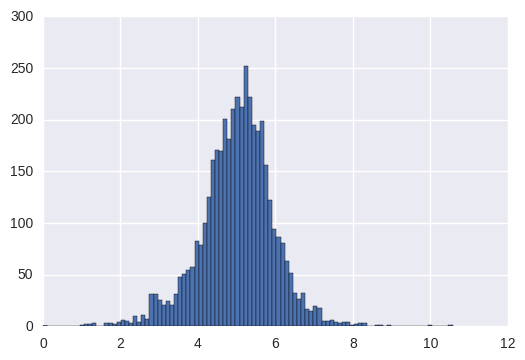

In [26]:
y.hist(bins=100)

### Model selection and Hyper parameters tuning


We data consists of time series. Each event (a purchase order) is related to the previous purchase order.
We define the last purchase order value **order_1** as the target.
As we have seen during the EDA, the previous orders suffer from multicollinearity. 
Using a XGBoosting regressor allow us to bypass this problem, avoid having to regularize all the features and define weights on the previous orders sequence (previous order more important than the 10th for instance, using an exponential scaling)

In [27]:
params = {
    'max_depth':[9],
    'min_child_weight':[5],
    'learning_rate' :[0.1],
    'gamma':[0.0]
}

def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=params, cv=n_folds, n_jobs=-1)
    gs.fit(Xtrain, ytrain)
    
    return gs.best_estimator_  

#### Cross Validation with GridSearch

In [28]:
clf = xgboost.XGBRegressor()

best_clf = cv_optimize(clf,params,X_train,y_train)

print(best_clf)


XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.0, learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=5, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


### Model performances

In [32]:
print "\n R2 on train data :{0}".format(best_clf.score(X_train,y_train))
print "\n R2 on test data :{0}".format(best_clf.score(X_test,y_test))


 R2 on train data :0.994506649123

 R2 on test data :0.766004427626


We clearly overfit on the training set.
On the testing set, we manage to explain 76% of the variance of the last purchase order, which is not optimal, taking into acocunt the Product family would have probably significantly improve the result.
As a benchmark, a simple linear regression on the full dataset produced a R-squared of 0.65.

#### Features importance

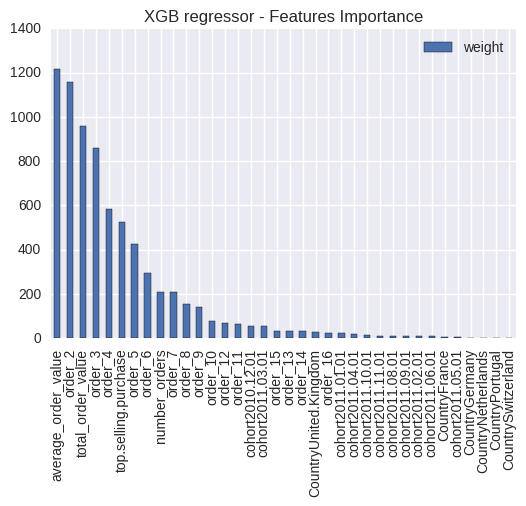

In [33]:
features_weights = pd.DataFrame.from_dict(best_clf.booster().get_fscore(),orient="index")
features_weights.columns = ['weight']

features_weights.sort_values(by='weight',ascending=False).plot(kind='bar',title='XGB regressor - Features Importance')

As we can observe with this chart, the main feature is the **average order value**, which is not suprising.
How would a model using only this feature have performed ?

In [36]:
r2_score(df.average_order_value,df.order_1)

0.40852117769571328

Ok, using the others features still helped.

- The second features in term of importance is the **previous order value**, not very suprising.
- **Top 100 selling products** ranks 6th, meaning we should investigate further the clustering per products.
- **The cohorts** have a low impact, maybe redefing them using the time of purchase pattern would help.
- And finally, regarding the **country**
predictor, we could simply replace it with a simple boolean *Is UK Customer*.


#### Residuals

/home/ramon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Average purchase order value : 230.50 (GBP)
Average absolute residuals on predicted order value : 45.90 (GBP)


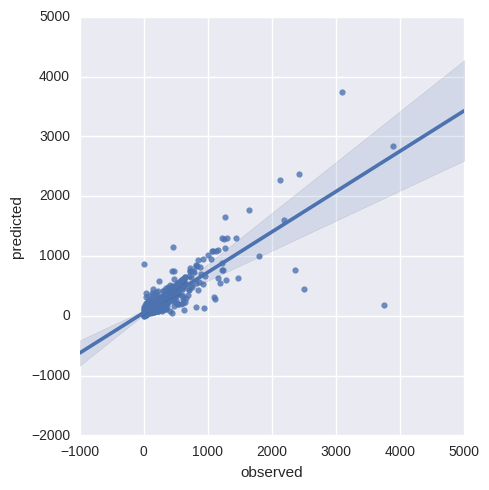

In [47]:
predictions = np.expm1(best_clf.predict(X_test))
df_prediction = pd.DataFrame({'predicted': predictions})
df_prediction['observed']= np.expm1(y_test.values)
df_prediction = df_prediction.sort_values(by='observed')
df_prediction['residuals']= df_prediction.observed-df_prediction.predicted
df_prediction = df_prediction.reset_index()[np.abs(df_prediction.residuals)<500]

sns.lmplot(x='observed',y='predicted',data=df_prediction,fit_reg=True) 

print "Average purchase order value : {0:.2f} (GBP)".format(np.mean(np.expm1(y_test)))
print "Average absolute residuals on predicted order value : {0:.2f} (GBP)".format(np.mean(np.abs(df_prediction.residuals)))

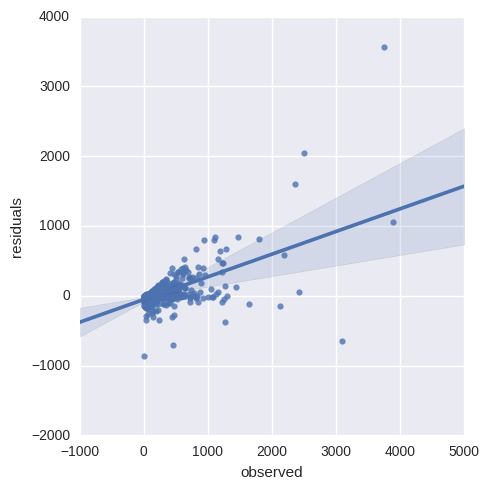

In [46]:
sns.lmplot(x='observed',y='residuals',data=df_prediction,fit_reg=True) 

The residuals are not well balanced beyond 2000 GBP along the real order value, which means we should exclude the outliers then.

### Conclusion

The model does not perform well enough for a production use but gives an insight of the relevant features.
Due to the time constraint and my limited skills, i did not try to implement the following models :
- use of **ARIMA** with clusters of customer defined by their Product Family,
- use of an **Markov Chain** approach with pyMC for times Series analysis.